# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [525]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.




## Introduction: Business Problem <a name="introduction"></a>

John lives and works in Bronx, New York. He has been offered a new work opportunity to work in Staten Island which is far from his home in his neighborhood.
John is willing to accept the job offer if he manages to find a neighborhood in Staten Island similar to his neighborhood in Bronx where he can move in.
We can help john take a decision by looking for similar neighborhoods in Staten Island where he can live near his new job. 

What Staten Island neighborhoods could be similar to John’s neighborhood?

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by John.

## Data <a name="data"></a>

We will need data from Staten Island, NY and john’s neighborhood. 
The data must include:
* Neighborhood name, latitude and longitude of each neighborhood in Staten Island.
* Neighborhood name, latitude and longitude of each neighborhood of John’s address.

Then, we analyze each neighborhood by calling foursquare venues and their categories in order to rank each neighborhood from Staten Island. The same analysis must be done on John’s neighborhood while normalizing the ranking of the neighborhoods from Staten island and John’s neighborhood.

### Neighborhoods of New York

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


In [526]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


In [1042]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
#newyork_data

In [1043]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


In [633]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_NewYork = pd.DataFrame(columns=column_names)
#adding data to df from list
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_NewYork = df_NewYork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
df_NewYork.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [634]:
df_NewYork.shape

(306, 4)

#### Let's take Staten Islan data


In [882]:
df_SI=df_NewYork[df_NewYork['Borough']=='Staten Island'].reset_index(drop=True)
df_SI.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [883]:
df_SI.shape

(63, 4)

#### Let's now get John's adress latitude and longitude
John lives in: 522 E 189th St Belmont The Bronx, NY


In [1013]:
address = '522 E 189th St Belmont The Bronx, NY'

geolocator = Nominatim(user_agent="ny_explorer")
John_location = geolocator.geocode(address)
John_latitude = John_location.latitude
John_longitude = John_location.longitude
print('The geograpical coordinate of John adress are {}, {}.'.format(
    John_latitude, John_longitude))

The geograpical coordinate of John adress are 40.859823, -73.8906714.


#### We add John Adress to the dataframe



In [885]:
john_row={'Borough':'Bronx',
          'Neighborhood':'Belmont',
          'Longitude':John_longitude,
          'Latitude':John_latitude
         }
df_SI=df_SI.append(john_row, ignore_index=True)
df_SI.tail()

,Borough,Neighborhood,Latitude,Longitude
59,Staten Island,Prince's Bay,40.526264,-74.201526
60,Staten Island,Lighthouse Hill,40.576506,-74.137927
61,Staten Island,Richmond Valley,40.519541,-74.229571
62,Staten Island,Fox Hills,40.617311,-74.081740
63,Bronx,Belmont,40.859823,-73.890671


#### Now we create a map of Staten island neighborhoods along john's adress


In [886]:
# create map of New York using latitude and longitude values
map_01 = folium.Map(location=[John_latitude, John_longitude], zoom_start=9)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_SI['Latitude'],
                                           df_SI['Longitude'],
                                           df_SI['Borough'],
                                           df_SI['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_01)  
    
map_01
#map_01.save('map_01.html')

#### Maps are rendered as html pages if not showing , please see git repositry


## Methodology <a name="Methodlogy"></a>

### Foursquare
Now that we have our locations, let's use Foursquare API to get infos on each neighborhood.

We're interested in venues call in order to categorize our neighborhood

#### Define Foursquare Credentials and Version


In [661]:
CLIENT_ID = 'N4JYMKA3RZZCDDNABWVMV3D4HNAXHKKUVYJQBZNBTUKOPICV' # your Foursquare ID
CLIENT_SECRET = 'E4DMWWD0YZXEZNRI3PDGAGZ2T1KWABFJWSQPD5EXEJISGBP2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: N4JYMKA3RZZCDDNABWVMV3D4HNAXHKKUVYJQBZNBTUKOPICV
CLIENT_SECRET:E4DMWWD0YZXEZNRI3PDGAGZ2T1KWABFJWSQPD5EXEJISGBP2


#### Let's create a function to get the top venues of our data in a radius of 800 m

In [887]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called  Data_venues


In [888]:
# type your answer here
Data_venues = getNearbyVenues(names=df_SI['Neighborhood'],
                                   latitudes=df_SI['Latitude'],
                                   longitudes=df_SI['Longitude']
                                  )

St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills
Belmont


### Let's fetch for the most abundant venues category in John's adress

In [976]:
df_Belmont=Data_venues[Data_venues['Neighborhood']=='Belmont'][['Neighborhood','Venue Category']]
df_Belmont.index=np.arange(len(df_Belmont))
Venues_Belmont=df_Belmont.groupby(['Venue Category']).count()
Venues_Belmont=Venues_Belmont.sort_values('Neighborhood',ascending=False)
Venues_Belmont.columns=['Belmont']
Belmont_top_cat=Venues_Belmont.head(8).index.to_list()

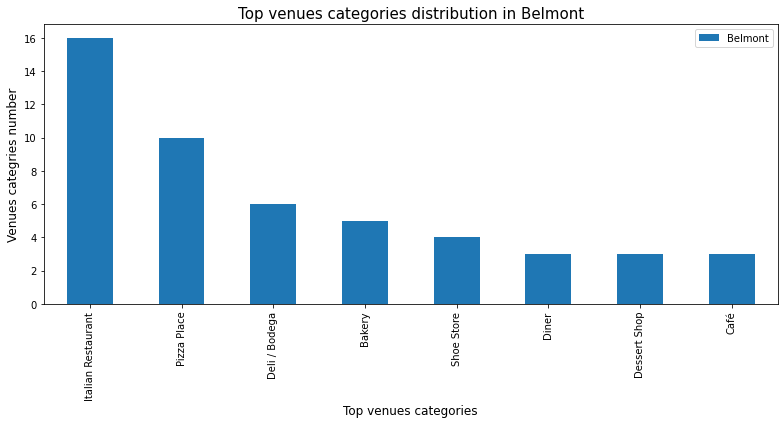

In [977]:
Venues_Belmont.head(8).plot(kind='bar',figsize=(11,6))
plt.title('Top venues categories distribution in Belmont',size=15,color='black')
plt.xlabel('Top venues categories',size=12)
plt.ylabel('Venues categries number',size=12)
plt.tight_layout()
plt.savefig('img1.png')

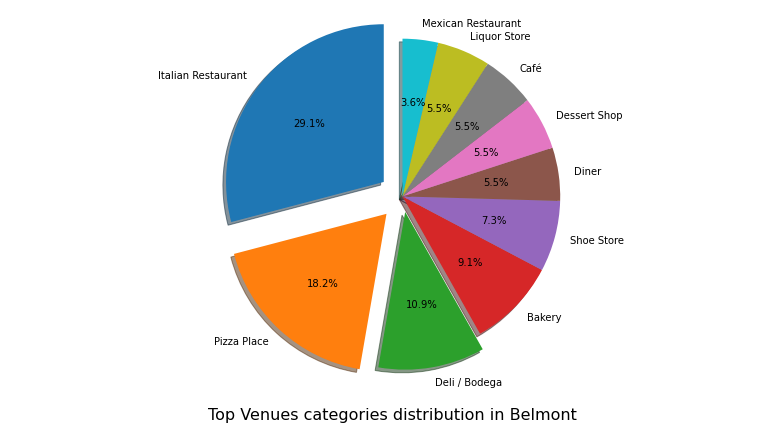

In [978]:
labels = Venues_Belmont.head(10).index.to_list()
sizes = Venues_Belmont.head(10)['Belmont'].to_list()
lst=np.zeros(len(labels))
lst[0]=0.15
lst[1]=.15
lst[2]=.1
exp=tuple(lst)
##
fig1, ax1 = plt.subplots(figsize=(11,6))
ax1.pie(sizes ,labels=labels, explode= exp, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Top Venues categories distribution in Belmont', y=-0.1,
              color='black',size=16)
plt.tight_layout()
plt.savefig('img2.png')

#### John lives in a Neighberhood with a lot of italian restaurants and many proximity shops for food and drinks

How many vanues categories do we have in our data ?

In [979]:
print(Data_venues.shape)
len(Data_venues['Venue Category'].unique())

(1743, 7)


212

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. **First let's do onehot enconding to venues category**:

In [896]:
# one hot encoding
df_onehot = pd.get_dummies(Data_venues[['Venue Category']],
                                  prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = Data_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]


df_onehot.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,St. George,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,St. George,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,St. George,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,St. George,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,St. George,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Now let's group our venue category by neighberhood


In [897]:
df_grouped=df_onehot.groupby('Neighborhood').mean().reset_index()
df_grouped.head()

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Annadale,0.133333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.000000,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bay Terrace,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's print each neighborhood along with the top 10 most common venues


In [1044]:
"""
num_top_venues = 10

for hood in df_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
"""

'\nnum_top_venues = 10\n\nfor hood in df_grouped[\'Neighborhood\']:\n    print("----"+hood+"----")\n    temp = df_grouped[df_grouped[\'Neighborhood\'] == hood].T.reset_index()\n    temp.columns = [\'venue\',\'freq\']\n    temp = temp.iloc[1:]\n    temp[\'freq\'] = temp[\'freq\'].astype(float)\n    temp = temp.round({\'freq\': 2})\n    print(temp.sort_values(\'freq\', ascending=False).reset_index(drop=True).head(num_top_venues))\n    print(\'\n\')\n'

In [967]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Let's put that into a _pandas_ dataframe


In [968]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

df_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,American Restaurant,Pizza Place,Restaurant,Bus Stop,Park,Trail,Train Station,Home Service,Dance Studio,Deli / Bodega
1,Arden Heights,Sandwich Place,Bagel Shop,Food,Sushi Restaurant,Shopping Mall,Mexican Restaurant,Optical Shop,Coffee Shop,Bus Stop,Bank
2,Arlington,Bus Stop,Deli / Bodega,Boat or Ferry,Grocery Store,Home Service,Snack Place,Construction & Landscaping,Coffee Shop,Yoga Studio,Food Truck
3,Arrochar,Bus Stop,Deli / Bodega,Baseball Field,Italian Restaurant,Cosmetics Shop,Beach,Pharmacy,Food Truck,Middle Eastern Restaurant,Sculpture Garden
4,Bay Terrace,Donut Shop,Supermarket,American Restaurant,Sushi Restaurant,Italian Restaurant,Liquor Store,Food Truck,Food & Drink Shop,Playground,Salon / Barbershop


## Clustering the neighborhoods

In [987]:
# set number of clusters
kclusters = 5

df_grouped_clustering = df_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,n_init=10,
                init='random',random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 4, 4, 0, 0, 0, 3, 1, 3], dtype=int32)

In [988]:
# add clustering labels
df_venues_sorted['Cluster Labels']=kmeans.labels_

df_merged = df_SI

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(df_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Staten Island,St. George,40.644982,-74.079353,Clothing Store,Deli / Bodega,Italian Restaurant,Bar,Sporting Goods Shop,Pharmacy,Pizza Place,Sandwich Place,American Restaurant,Rock Club,0
1,Staten Island,New Brighton,40.640615,-74.087017,Deli / Bodega,Mexican Restaurant,Indian Restaurant,Park,Food Truck,Bus Stop,Garden Center,Boat or Ferry,Farmers Market,Sri Lankan Restaurant,4
2,Staten Island,Stapleton,40.626928,-74.077902,Deli / Bodega,Sandwich Place,Discount Store,Pizza Place,Bank,Sri Lankan Restaurant,Spanish Restaurant,Donut Shop,Bus Stop,Miscellaneous Shop,0
3,Staten Island,Rosebank,40.615305,-74.069805,Mexican Restaurant,Chinese Restaurant,Deli / Bodega,Beach,Train Station,Pizza Place,Grocery Store,Italian Restaurant,Gastropub,Filipino Restaurant,3
4,Staten Island,West Brighton,40.631879,-74.107182,Pizza Place,Bus Stop,Italian Restaurant,Coffee Shop,Bagel Shop,Food & Drink Shop,Bank,Bar,Fast Food Restaurant,Ice Cream Shop,0


In [989]:
# create map
map_02 = folium.Map(location=[John_latitude, John_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'],
                                  df_merged['Longitude'],
                                  df_merged['Neighborhood'],
                                  df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_02)
       
map_02
map_02.save('map_02.html')

In [1039]:
print('==============================================================')
belmont_cluster=df_venues_sorted[df_venues_sorted['Neighborhood']=='Belmont']['Cluster Labels'].values[0]
df_final=df_venues_sorted[df_venues_sorted['Cluster Labels']==belmont_cluster]
neigh_lst=df_final['Neighborhood'].to_list()
print('Addresses of Staten Island similar to John neighborhood in Belmont:',len(neigh_lst)-1)
print('==============================================================\n')
neigh_lst

Addresses of Staten Island similar to John neighborhood in Belmont: 24



['Annadale',
 'Bay Terrace',
 'Belmont',
 'Bloomfield',
 'Charleston',
 'Chelsea',
 'Egbertville',
 'Grant City',
 'Great Kills',
 'Grymes Hill',
 'Howland Hook',
 'Huguenot',
 'Lighthouse Hill',
 'New Dorp',
 'New Dorp Beach',
 'Old Town',
 'Pleasant Plains',
 'Richmond Valley',
 'Silver Lake',
 'St. George',
 'Stapleton',
 'Tompkinsville',
 'Tottenville',
 'Travis',
 'West Brighton']

### Ordering the results by Bakery since John has a preference for Bakery shops

In [1036]:
dt=df_grouped.set_index('Neighborhood')
dt=dt[Belmont_top_cat].loc[neigh_lst]

In [1037]:
dt=dt.sort_values('Bakery',ascending=False).head(10)

### Let's plot distribution of top venues categories of Belmont in the neighborhoods in Staten Islan similar to Belmont

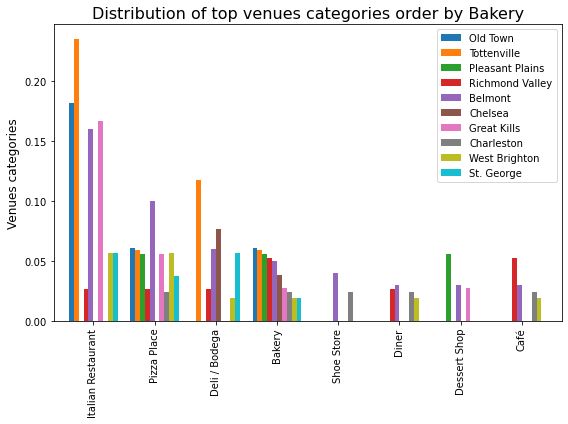

In [1038]:
dt.transpose().plot(kind='bar',width=0.8,figsize=(8,6))
plt.title('Distribution of top venues categories order by Bakery',color='black',size=16)
plt.ylabel('perc %',color='black',size=12)
plt.legend(loc='upper right')
plt.ylabel('perc %',color='black',size=12)
plt.ylabel('Venues categories',color='black',size=12)
plt.tight_layout()
plt.savefig('img3.png')

This concludes our analysis.

We have created a final dataframe containing 24 Staten Island neighborhoods likely to be similar to John's neighborhood in Bronx.

The analysis was based on venues category in each neighborhood. John can now make a better decision based on the results of this clustering approach.

## Results and Discussion <a name="results"></a>

There are four neighbourhoods having approximately the same distribution of bakeries such as Belmont: Old Town, Tottenville, Pleasant Plains, Richmond Valley.

Tottenville and Great Kills have a significant distribution of the most common venues in Belmont but the less common venues are not well represented while West Brighton is well distributed between many most common venues of Belmont.


We can advise John to look for a new place in Tottenville if he is very interested in finding the four most common venues categories of Belmont (Italian restaurant, Pizza place, Deli/Bodega and bakery). Otherwise, if John is more interested in the overall most common venues categories, we could advise him West Brightont or Richmond valley.

## Conclusion <a name="conclusion"></a>


Clustering of these neighbourhoods was performed in order to identify best Staten Island neighbourhoods having the 10 most common venues categories such as John' address in Belmont which are italian restaurant, pizza place, deli/bodega and bakry.

Final decision on optimal neighbourhoods gives John the choice between 24 neighbourhoods having the similar common venues categories distribution such as his current address.
We have made recommendations of 5 neighbourhoods from the 24 neighbourhoods found.


John knows now that there are similar neighbourhoods in Staten Island and he could accept the new job offer. A further analysis could be improving the decision by narrowing the final list of 24 neighbourhoods by adding features such as proximity to his new work, proximity to airport or rent price.